# Рынок заведений общественного питания Москвы

## Изучение и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from scipy import stats as st
from datetime import datetime, timedelta

<div style="border:solid blue 1px; padding: 20px"> 
Сохраним данные о заведениях общественного питания Москвы

In [2]:
data = pd.read_csv('/datasets/rest_data.csv')

In [3]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


<div style="border:solid blue 1px; padding: 20px"> 
Пропусков в данных нет, проверим их на наличие дубликатов

In [5]:
data['id'].duplicated().sum()

0

In [6]:
data['object_type'].value_counts()

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data_pt = data.pivot_table(index=['object_name','object_type'], values='id', aggfunc='count')

In [8]:
display(data_pt.query('id >= 2').head())

,,id
object_name,object_type,
24 Градуса,бар,3
BB&Burgers,кафе,3
Bocconcino,ресторан,2
Burger Club,кафе,2
Burger Heroes,кафе,2


<div style="border:solid blue 1px; padding: 20px"> 
По сводной таблице видно, что присутствуют неявные дубликаты в столбце "название объекта общественного питания".
Также видно, что заведения одной сети могут относиться к нескольким типам объекта общественного питания (кафе/ресторан и т.п.).
    
Вручную заменить названия по каждому объекту очень долгий процесс, поэтому ограничимся следующими операциями: приведем все значения в столбце "название объекта общественного питания" к нижнему регистру, уберем специальные символы, заменим "ё" на "е".

In [9]:
data['object_name'] = data['object_name'].str.lower()

In [10]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [11]:
data['object_name'] = data['object_name'].str.replace('ё','е')
data['object_name'] = data['object_name'].str.replace('-','')
data['object_name'] = data['object_name'].str.replace('_','')
data['object_name'] = data['object_name'].str.replace('"','')
data['object_name'] = data['object_name'].str.replace("'",'')
data['object_name'] = data['object_name'].str.replace("«",'')
data['object_name'] = data['object_name'].str.replace("»",'')
data['object_name'] = data['object_name'].str.replace(".",'')

/tmp/ipykernel_469/2073281274.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  data['object_name'] = data['object_name'].str.replace(".",'')


In [12]:
data.head()

,id,object_name,chain,object_type,address,number
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<div style="border:solid blue 1px; padding: 20px"> 
Далее проработаем вопрос наличия нескольких типов объекта общественного питания для одной сети.
Найдем самый многочисленный тип по каждой сети заведений и добавим его в колонку object_type_upd.

In [13]:
types = data.groupby(['object_name', 'object_type']).agg({'object_type':'count'})

In [15]:
types.head()

,,object_type
object_name,object_type,
100 личная столовая,столовая,1
100 личное кафе,кафе,1
1001 ночь,ресторан,1
100лоффка,столовая,1
101 вкус,кафе,1


In [16]:
types.columns = ['qty']

In [17]:
types.reset_index(inplace=True)
display(types.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10583 entries, 0 to 10582
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  10583 non-null  object
 1   object_type  10583 non-null  object
 2   qty          10583 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 248.2+ KB


None

In [18]:
types_2 = types[['object_name', 'qty']].groupby(by='object_name', as_index=False).max()

In [19]:
types_max = (pd.merge(types_2, types, on=['object_name', 'qty'], how='left')
             .sort_values(['object_name', 'qty'], ascending=False))

In [20]:
#types_max

In [21]:
# КОДРЕВЬЮЕРА
types_max.head()

,object_name,qty,object_type
10107,яуза,1,ресторан
10105,ясон,1,кафе
10106,ясон,1,ресторан
10103,ясмин,1,кафе
10104,ясмин,1,ресторан


In [22]:
types_max = types_max.drop_duplicates(subset='object_name', keep='first', inplace=False, ignore_index=False)

In [23]:
types_max.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9810 entries, 10107 to 0
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   object_name  9810 non-null   object
 1   qty          9810 non-null   int64 
 2   object_type  9810 non-null   object
dtypes: int64(1), object(2)
memory usage: 306.6+ KB


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [25]:
data = pd.merge(data, types_max, on='object_name', how='left')

In [26]:
data.head()

,id,object_name,chain,object_type_x,address,number,qty,object_type_y
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,1,кафе
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,1,кафе
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,1,кафе
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,2,кафе
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,1,кафе


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15366 entries, 0 to 15365
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             15366 non-null  int64 
 1   object_name    15366 non-null  object
 2   chain          15366 non-null  object
 3   object_type_x  15366 non-null  object
 4   address        15366 non-null  object
 5   number         15366 non-null  int64 
 6   qty            15366 non-null  int64 
 7   object_type_y  15366 non-null  object
dtypes: int64(3), object(5)
memory usage: 1.1+ MB


In [28]:
data = data.rename(columns={'object_type_y':'object_type_upd', 'object_type_x':'object_type'})
data = data.drop(['qty'], axis=1)

In [29]:
data.head()

,id,object_name,chain,object_type,address,number,object_type_upd
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,кафе
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,кафе
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе


<div style="border:solid blue 1px; padding: 20px"> 
Проверим данные на явные дубликаты

In [30]:
data.duplicated().sum()

0

<div style="border:solid blue 1px; padding: 20px"> 
Явных дубликатов нет

### Вывод
В данных были найдены неявные дубликаты: некоторые заведения сети дублируются под разными названиями.
Для этого значения столбца "название объекта общественного питания" были приведены к нижнему регистру, были удалены специальные символы.

Так же в одной сети встречаются заведения разного типа (например, KFC - ресторан быстрого питания / кафе / ресторан). Для унификации был добавлен столбец "object_type_upd", в котором отражается наиболее полпулярный тип заведения по каждой сети ресторанов.

## Анализ данных

### Исследуйте соотношение видов объектов общественного питания по количеству. Постройте график.

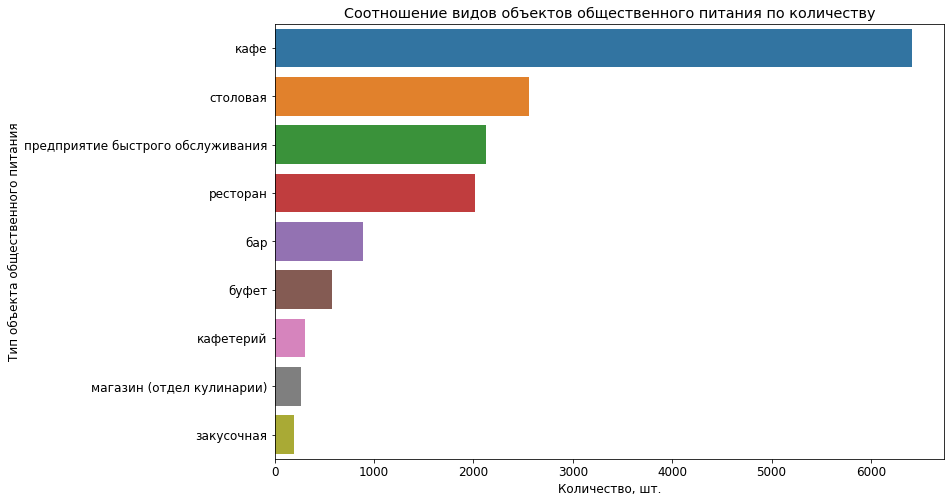

In [31]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '12'
sb.countplot(y=data['object_type_upd'], order=data['object_type_upd']
             .value_counts().sort_values(ascending=False).index)
plt.ylabel('Тип объекта общественного питания')
plt.xlabel('Количество, шт.')
plt.title('Соотношение видов объектов общественного питания по количеству')
plt.show()

Самый популярный тип общественного питания - это кафе (около 6 тыс.), далее идут столовая (около 2,5 тыс.), предприятие быстрого обслуживания и ресторан (около 2 тыс.)

### Исследуйте соотношение сетевых и несетевых заведений по количеству. Постройте график.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


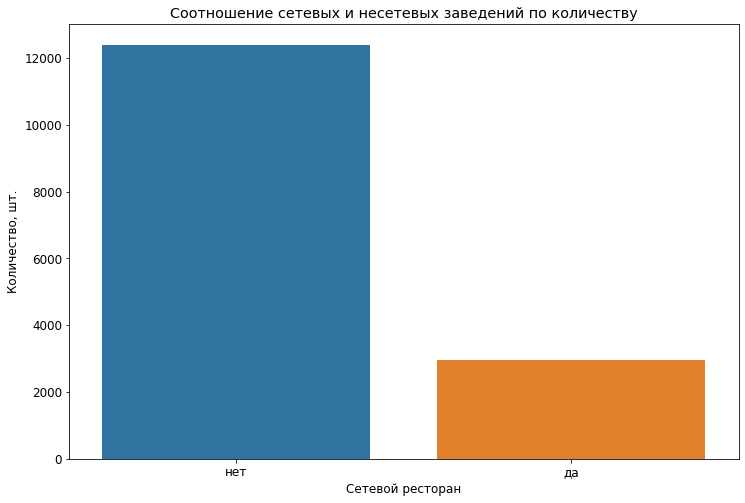

In [32]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '12'
sb.countplot(data['chain'])

plt.ylabel('Количество, шт.')
plt.xlabel('Сетевой ресторан')
plt.title('Соотношение сетевых и несетевых заведений по количеству')
plt.show()

Большинство заведений не сетевые (~ 80%).

### Для какого вида объекта общественного питания характерно сетевое распространение?

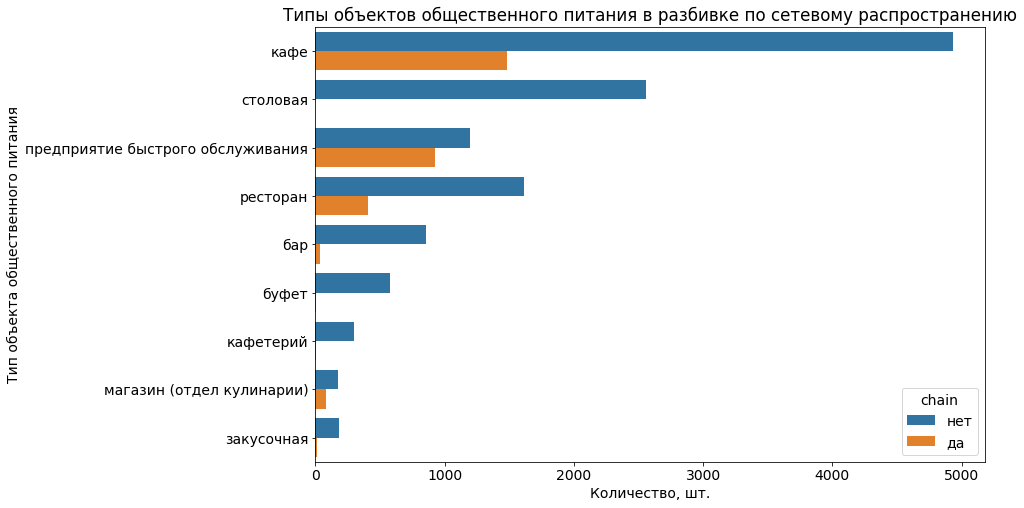

In [33]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '14'
sb.countplot(y=data['object_type_upd'], hue=data['chain'], order=data['object_type_upd']
             .value_counts().sort_values(ascending=False).index)
plt.ylabel('Тип объекта общественного питания')
plt.xlabel('Количество, шт.')
plt.title('Типы объектов общественного питания в разбивке по сетевому распространению')
plt.show()

In [34]:
chain_pt = (data.pivot_table(index='object_type_upd', columns='chain', values='id', aggfunc='count')
            .reset_index())

In [35]:
chain_pt.columns = ['object_type_upd', 'yes', 'no']

In [36]:
chain_pt['percent'] = chain_pt['yes']/(chain_pt['yes']+chain_pt['no']) * 100

In [37]:
chain_pt = chain_pt.sort_values('percent', ascending=False)

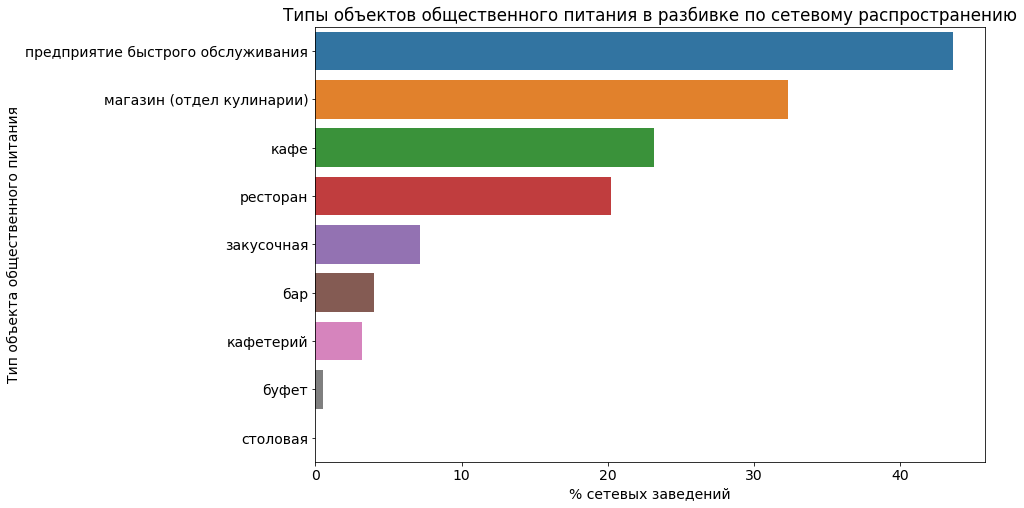

In [38]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '14'
sb.barplot(y=chain_pt['object_type_upd'], x=chain_pt['percent'])
plt.ylabel('Тип объекта общественного питания')
plt.xlabel('% сетевых заведений')
plt.title('Типы объектов общественного питания в разбивке по сетевому распространению')
plt.show()

Больше всего сетевых заведений типа кафе, около 1,5 тыс.
Но в % соотношении больше всего сетевых заведений у предприятий быстрого обслуживания (~ 42%), далее у отделов кулинарии в магазинах (~ 32%) и только потом у кафе (~22%).

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест

In [39]:
chain_number = data[data['chain']=='да'].groupby('object_name').agg({'id':'count', 'number':'mean'})

In [40]:
chain_number.columns = ['id_qty', 'mean_number_qty']

In [41]:
chain_number['mean_number_qty'] = round(chain_number['mean_number_qty'])

In [42]:
chain_number.describe()

,id_qty,mean_number_qty
count,552.000000,552.000000
mean,5.376812,58.938406
std,15.882944,53.753148
min,1.000000,0.000000
25%,1.000000,20.000000
50%,1.000000,45.000000
75%,3.000000,82.250000
max,157.000000,306.000000


In [43]:
chain_number.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552 entries, beverly hills diner to япоша
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_qty           552 non-null    int64  
 1   mean_number_qty  552 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 12.9+ KB


Видно, что в выборке много сетей всего с 1 заведением, но характеризующиеся как сетевые.
Удалим их из наших расчетов.

In [44]:
chain_number = chain_number.query('id_qty > 1')

In [45]:
chain_number.describe()

,id_qty,mean_number_qty
count,250.000000,250.000000
mean,10.664000,59.212000
std,22.515124,50.008263
min,2.000000,0.000000
25%,2.000000,21.000000
50%,3.500000,44.000000
75%,7.000000,85.000000
max,157.000000,259.000000


In [46]:
chain_number.info()

<class 'pandas.core.frame.DataFrame'>
Index: 250 entries, bocconcino to япоша
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id_qty           250 non-null    int64  
 1   mean_number_qty  250 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 5.9+ KB


Поделим сетевые заведения на 4 категории: мало заведений и мало посадочных мест; мало заведений и много посадочных мест; много заведений и мало посадочных мест; много заведений и много посадочных мест.

За условную границу возьмем 11 заведений в сети и 60 посадочных мест. Следовательно, если в сети больше 11 заведений и в среднем больше 60 посадочных мест, то она относится к категории много заведений и много посадочных мест (и т.п.).

In [47]:
def category (row):
    number = row['mean_number_qty']
    qty = row['id_qty']
    
    if number >= 60 and qty >= 11:
        return 'много заведений и много посадочных мест'
    if number >= 60 and qty <= 11:
        return 'мало заведений и много посадочных мест'
    if number <= 60 and qty >= 11:
        return 'много заведений и мало посадочных мест'
    if number <= 60 and qty <= 11:
        return 'мало заведений и мало посадочных мест'

In [48]:
chain_number['category'] = chain_number.apply(category, axis=1)

In [49]:
chain_number.head()

,id_qty,mean_number_qty,category
object_name,,,
bocconcino,3,67.0,мало заведений и много посадочных мест
burger club,3,20.0,мало заведений и мало посадочных мест
coffeeshop company,4,47.0,мало заведений и мало посадочных мест
cofix,25,10.0,много заведений и мало посадочных мест
correas,3,44.0,мало заведений и мало посадочных мест


In [50]:
chain_number.groupby('category').agg({'id_qty':'count'})

,id_qty
category,
мало заведений и мало посадочных мест,121
мало заведений и много посадочных мест,83
много заведений и мало посадочных мест,35
много заведений и много посадочных мест,11


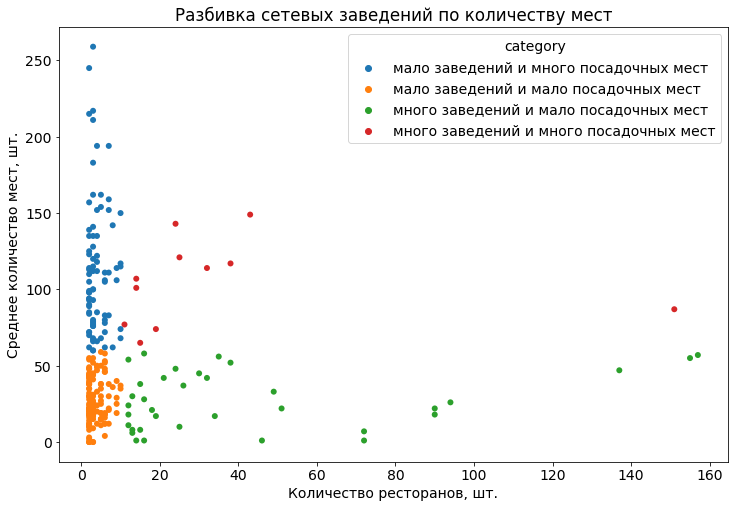

In [51]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '14'
sb.scatterplot(x='id_qty', y='mean_number_qty', data=chain_number, hue='category', ec=None)
plt.ylabel('Среднее количество мест, шт.')
plt.xlabel('Количество ресторанов, шт.')
plt.title('Разбивка сетевых заведений по количеству мест')
plt.show()

Таким образом больше всего заведений с небольшим количеством заведений и небольшим количеством посадочных мест.

### Для каждого вида объекта общественного питания опишите среднее количество посадочных мест. Какой вид предоставляет в среднем самое большое количество посадочных мест? Постройте графики.

In [52]:
mean_number_pt = (data.pivot_table(index='object_type_upd', values='number', aggfunc='mean')
            .reset_index().sort_values('number', ascending=False))

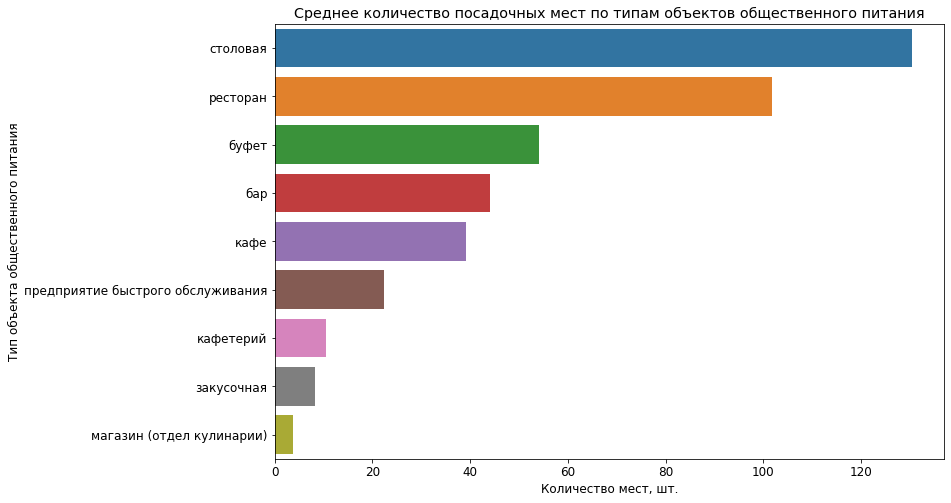

In [53]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '12'
sb.barplot(y=mean_number_pt['object_type_upd'], x=mean_number_pt['number'])
plt.ylabel('Тип объекта общественного питания')
plt.xlabel('Количество мест, шт.')
plt.title('Среднее количество посадочных мест по типам объектов общественного питания')
plt.show()

В среднем в кафе (самом популярном типе заведения) около 40 мест. Больше всего мест в столовых и ресторанах - ~ 130 и 100 мест соответственно. Меньше всего мест в закусочных и отделах кулинарии.

### Выделите в отдельный столбец информацию об улице из столбца address .

Для этого отберем часть строки, начиная со 2 запятой, где указана улица города.

In [54]:
data['address'] = data['address'].str.replace('ё','е')
import re
def street (row):
    i = row['address']
    a=re.search(',[0-9 А-я -]+', i).group()
    return a
data['street'] = data.apply(street, axis=1)

In [55]:
data.head()

,id,object_name,chain,object_type,address,number,object_type_upd,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,кафе,", улица Егора Абакумова"
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,кафе,", улица Талалихина"
2,24309,кафе академия,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе,", Абельмановская улица"
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,кафе,", Абрамцевская улица"
4,119365,кафе вишневая метель,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе,", Абрамцевская улица"


In [57]:
data[['address','street']].head()

,address,street
0,"город Москва, улица Егора Абакумова, дом 9",", улица Егора Абакумова"
1,"город Москва, улица Талалихина, дом 2/1, корпус 1",", улица Талалихина"
2,"город Москва, Абельмановская улица, дом 6",", Абельмановская улица"
3,"город Москва, Абрамцевская улица, дом 1",", Абрамцевская улица"
4,"город Москва, Абрамцевская улица, дом 9, корпус 1",", Абрамцевская улица"


В данных присутствуют также улицы городов Троицк, Щербинка, Зеленоград, различных поселений. Названия городов и поселений идут после указания города Москвы и поэтому попали в наш фильтр вместо улиц. Создадим отдельный столбец, в котором проверим вхождение слов поселение и город в колонку street. При нахождении, такое заведение не будем рассматривать в топ улиц Москвы.

In [58]:
data['check'] = data['street'].str.find('поселение ') != -1
data['check_2'] = data['street'].str.find('город ') != -1

In [60]:
data[data['check']==True].head()

,id,object_name,chain,object_type,address,number,object_type_upd,street,check,check_2
1853,77651,щербенко ла,нет,кафе,"город Москва, поселение Вороновское, село Воро...",50,кафе,", поселение Вороновское",True,False
1854,128021,кафе мама миа,нет,кафе,"город Москва, поселение Внуковское, улица Летч...",12,кафе,", поселение Внуковское",True,False
1855,120299,пиццерия,нет,кафе,"город Москва, поселение Внуковское, улица Летч...",24,кафе,", поселение Внуковское",True,False
1856,125246,суши wok,да,кафе,"город Москва, поселение Внуковское, улица Летч...",5,кафе,", поселение Внуковское",True,False
1857,151292,редкафе,нет,кафе,"город Москва, поселение Новофедоровское, дерев...",45,кафе,", поселение Новофедоровское",True,False


Удалим запятые из столбца street

In [61]:
data['street'] = data['street'].str.replace(", ",'')

### Постройте график топ-10 улиц по количеству объектов общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

Загрузим внешний файл с данными о районах Москвы

In [62]:
from io import BytesIO
import requests
spreadsheet_id = '1s5ma2Z0-g2AGLwPBFn8T3WzwUCVZAzXTK50GzO8hrQ0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
df = pd.read_csv(BytesIO(r.content))

In [63]:
df.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


Отсортируем данные по улицам и по количеству заведений, отберем 10 наиболее популярных улиц.

In [64]:
top_streets = data[(data['check']==False) & (data['check_2']==False)].groupby('street').agg({'id':'count'}).sort_values(by='id', ascending=False)

In [65]:
top_10 = top_streets.head(10)
top_10.columns = ['qty']
top_10 = top_10.reset_index()
display(top_10)
display(top_10.info())

,street,qty
0,проспект Мира,204
1,Профсоюзная улица,182
2,Ленинградский проспект,171
3,Пресненская набережная,167
4,Варшавское шоссе,161
5,Ленинский проспект,147
6,проспект Вернадского,132
7,Кутузовский проспект,114
8,Каширское шоссе,112
9,Кировоградская улица,110


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   street  10 non-null     object
 1   qty     10 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


None

Присоединим названия райнов к таблице с топ 10 улицами.

In [66]:
pd.merge(top_10, df, left_on='street', right_on='streetname', validate='one_to_many')

,street,qty,streetname,areaid,okrug,area
0,проспект Мира,204,проспект Мира,70,СВАО,Алексеевский район
1,проспект Мира,204,проспект Мира,86,СВАО,Ярославский Район
2,проспект Мира,204,проспект Мира,78,СВАО,Район Марьина роща
3,проспект Мира,204,проспект Мира,79,СВАО,Останкинский район
4,проспект Мира,204,проспект Мира,81,СВАО,Район Ростокино
5,проспект Мира,204,проспект Мира,82,СВАО,Район Свиблово
6,проспект Мира,204,проспект Мира,16,ЦАО,Мещанский район
7,Профсоюзная улица,182,Профсоюзная улица,123,ЮЗАО,Академический район
8,Профсоюзная улица,182,Профсоюзная улица,132,ЮЗАО,Район Черемушки
9,Профсоюзная улица,182,Профсоюзная улица,134,ЮЗАО,Район Ясенево


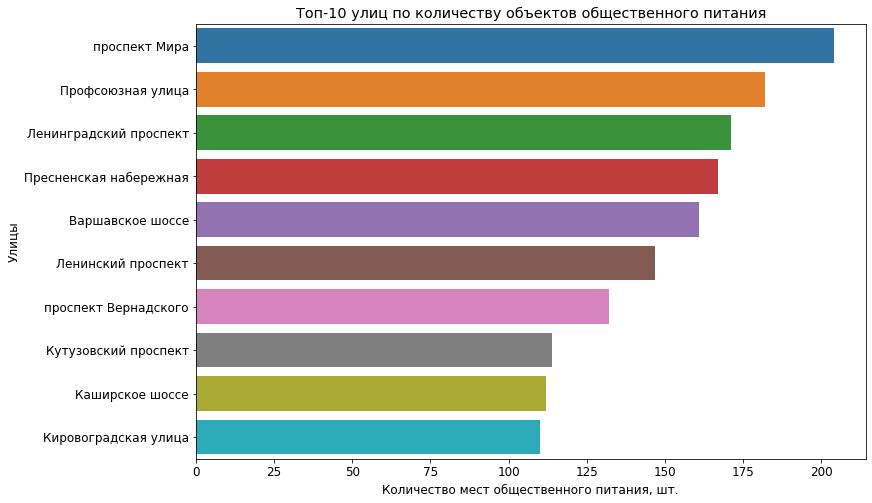

In [67]:
plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '12'
sb.barplot(y=top_10['street'],x=top_10['qty'])
plt.ylabel('Улицы')
plt.xlabel('Количество мест общественного питания, шт.')
plt.title('Топ-10 улиц по количеству объектов общественного питания')
plt.show()

Больше всего заведений на проспекте Мира, около 200. Он проходит через Алексеевский, Ярославский, Останкинский, Мещанский район, а также районы Марьина Роща, Ростокино, Свиблово. 
Как мы видим, большое число заведений находится не в центральном округе. Это можно объяснить более низкой стоимостью аренды, а также тем, что улицы выше одни из самых длинных в Москве, они проходят через большое количество районов. Как следствие, на них может располагаться большее количество заведений.

### Найдите число улиц с одним объектом общественного питания. Воспользуйтесь внешней информацией и ответьте на вопрос — в каких районах Москвы находятся эти улицы?

In [68]:
one_object = data[data['check']==False].groupby('street').agg({'id':'count'}).query('id == 1')

In [69]:
one_object_final = pd.merge(one_object, df, left_on='street', right_on='streetname', validate='one_to_many')

In [70]:
one_object_final_grouped = one_object_final.groupby(['area','okrug']).agg({'id':'count'}).sort_values(by='id', ascending=False)

,area,okrug,qty
0,Таганский район,ЦАО,27
1,Район Хамовники,ЦАО,24
2,Басманный район,ЦАО,21
3,Тверской район,ЦАО,20
4,Пресненский район,ЦАО,19
5,Район Марьина роща,СВАО,18
6,Район Арбат,ЦАО,17
7,Мещанский район,ЦАО,16
8,Район Сокольники,ВАО,15
9,Район Замоскворечье,ЦАО,14


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   area    10 non-null     object
 1   okrug   10 non-null     object
 2   qty     10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes


None

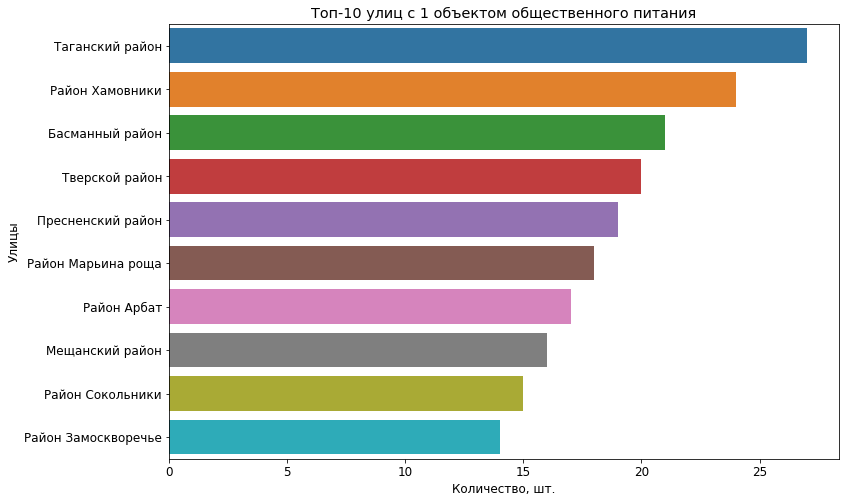

In [71]:
top_10_one_object = one_object_final_grouped.head(10)
top_10_one_object.columns = ['qty']
top_10_one_object = top_10_one_object.reset_index()
display(top_10_one_object)
display(top_10_one_object.info())

plt.figure(figsize=(12, 8))
plt.rcParams['font.size'] = '12'
sb.barplot(y=top_10_one_object['area'],x=top_10_one_object['qty'])
plt.ylabel('Улицы')
plt.xlabel('Количество, шт.')
plt.title('Топ-10 улиц с 1 объектом общественного питания')
plt.show()

In [72]:
one_object_final['streetname'].nunique() #количество улиц с 1 заведением

495

In [73]:
one_object_final_grouped #все районы,в которых есть улицы с 1 заведением

,,id
area,okrug,
Таганский район,ЦАО,27
Район Хамовники,ЦАО,24
Басманный район,ЦАО,21
Тверской район,ЦАО,20
Пресненский район,ЦАО,19
Район Марьина роща,СВАО,18
Район Арбат,ЦАО,17
Мещанский район,ЦАО,16
Район Сокольники,ВАО,15


Больше всего улиц с 1 заведением в ЦАО: в Таганском, Басманном, Тверском, Пресненском районах и районе Хамовники.
Меньше всего на юго-востоке Москвы (н-р, район Царицыно, Северное Измайлово).

### Вывод

Самый популярный тип заведения - кафе (50% выборки). При этом 80% заведений не сетевые. 

Для сетевых заведений характерно много заведений с небольшим числом посадочных мест в каждом. Больше всего сетей с небольшим количеством заведений и с небольшим количеством посадочных мест. 

Больше всего заведений общественного питания располагается на проспекте Мира (СВАО), который проходит через Алексеевский, Ярославский, Останкинский, Мещанский район, а также районы Марьина Роща, Ростокино, Свиблово.

В основном заведения общественного питания находятся не в центральном округе. Это можно объяснить более низкой стоимостью аренды, а также тем, что проспект Мира, Ленинский и Ленинградский проспект, Профсоюзная улица и Варшавское шоссе и т.д. одни из самых длинных в Москве, они проходят через большое количество районов. Как следствие, на них может располагаться большее количество заведений.

Всего в Москве 495 улиц с 1 заведением. Больше всего таких улиц в центре города, а именно в Таганском, Басманном, Тверском, Пресненском районах и районе Хамовники.

## Вывод

По итогам проведенного анализа можно сделать следующие выводы:

- лучше всего создавать кафе - это самый популярный тип заведения;
- с ~40 посадочными местами;
- в ЦАО (рассмотреть Таганский, Басманный, Тверской, Пресненский районы, район Хамовники). Именно там располагается наибольшее число улиц всего с 1 заведением. Планируется уникальный не сетевой проект. Его лучше всего расположить не на проходной улице, но в то же время с хорошей транспортной доступностью (ЦАО).